In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
from IPython.display import Audio
%matplotlib inline

In [2]:
outputs = h5py.File("/work/asr3/rossenbach/rilling/sisyphus_work_dirs/glow_tts_asr_v2/i6_core/returnn/forward/ReturnnForwardJob.HX9OXBi72McY/output/output.hdf", "r")
outputs.keys()

<KeysViewHDF5 ['inputs', 'labels', 'seqLengths', 'seqTags']>

In [3]:
spectograms = np.array(outputs["inputs"])
lengths = np.array(outputs["seqLengths"])[:, 0]
spectograms.shape, lengths[0]

((445634, 80), 406)

In [4]:
np.max(lengths)

1120

In [5]:
def get_spec_for_index(specs, lengths, index):
    start = 0
    end = 0
    for i in range(index+1):
        start = end
        end += lengths[i]
    return specs[start:end].T

In [6]:
index = 1
spec = get_spec_for_index(spectograms, lengths, index)

In [7]:
gt_specs = torch.load("/u/lukas.rilling/experiments/glow_tts_asr/audio_features_first_batch.pt").detach().cpu().numpy()

gt_spec = gt_specs[index]
gt_spec[index]


array([-3.9959576 , -3.9959576 , -3.9959576 , -3.6865392 , -3.153478  ,
       -2.6930926 , -1.1523093 ,  0.43198204,  1.1550909 ,  1.4025683 ,
        1.527397  ,  1.56907   ,  1.5516889 ,  1.5456281 ,  1.4740586 ,
        1.329414  ,  1.1731834 ,  0.95154476,  0.7052721 ,  0.45574147,
       -0.05051096, -0.7196447 , -0.80566025, -1.0119613 , -1.0753284 ,
       -1.428339  , -1.5747962 , -1.6023464 , -1.8086121 , -1.8187568 ,
       -1.9094514 , -1.5007291 , -1.1272069 , -1.1754792 , -0.9749154 ,
       -0.9304345 , -0.6772937 , -0.7408955 , -0.07841814,  0.33159846,
        0.44702363, -0.08244455, -0.8882897 , -1.2224141 , -1.3021836 ,
       -1.4218036 , -1.9107696 , -2.6159873 , -2.298411  , -2.2877178 ,
       -2.292805  , -2.4140427 , -1.9453388 , -0.39178482,  0.26470935,
        0.0364221 , -0.46991858, -0.22771479, -0.4003849 , -0.78991276,
       -0.5237579 ,  0.05165537,  0.4330782 ,  0.63122153,  0.7608849 ,
        0.65014786,  0.13441564, -0.62052083, -0.7421789 ,  0.51

In [8]:
def plot_spec(spec):
    fig, ax = plt.subplots()
    shape = spec.shape
    x = np.arange(0, shape[0]+1)
    y = np.arange(0, shape[1]+1)

    ax.pcolormesh(spec[:, :shape[1]])
    plt.show()


In [9]:
gt_spec.shape, spec.shape

((80, 411), (80, 442))

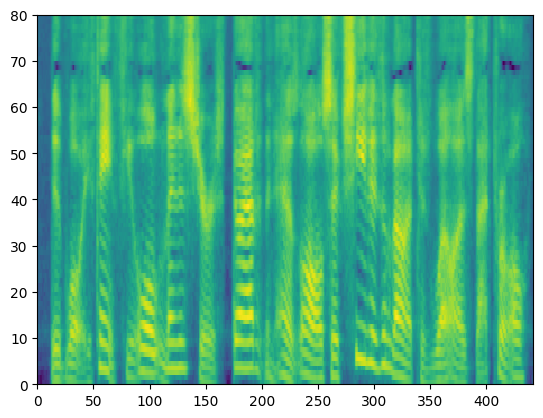

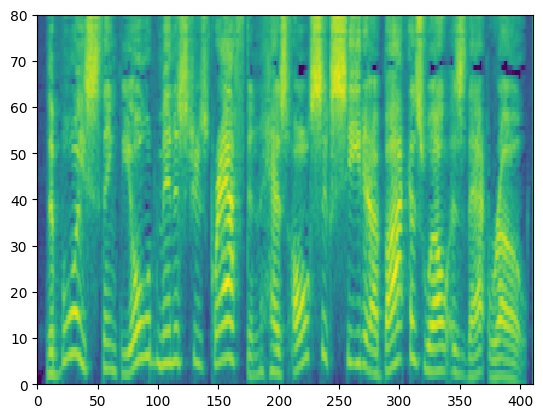

In [10]:
plot_spec(spec)
plot_spec(gt_spec[:, :spec.shape[1]])

In [11]:
def plot_waveform(waveform, sample_rate=16000, title="Waveform", xlim=None, ylim=None):
#   waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [12]:
def inv_preemphasis(wav, preemphasis):
        """
        :param np.array wav:
        :param float k:
        :return:
        """
        from scipy import signal
        return signal.lfilter([1], [1, -preemphasis], wav)

In [13]:
def get_waveform_of_spec(spec):
    norm_std_dev = 30.906690797087478
    norm_mean = -76.49818038940428

    # s = spec.detach().cpu().numpy()
    s = spec.copy()
    print(np.min(s), np.max(s))
    s *= norm_std_dev
    s += norm_mean
    s /= 20
    s = np.power(10,s)
    print(np.min(s), np.max(s))
    num_freq = 1024
    iverse_mel = torchaudio.transforms.InverseMelScale(num_freq // 2 + 1, 80, f_min=60, f_max=7600, sample_rate=16000)
    spec_tensor = torch.Tensor(s)
    power_spec = iverse_mel(spec_tensor)
    
    power_spec[:5,:] = 0
    power_spec[-55:,:] = 0
    plot_spec(power_spec)
    print(torch.sum(power_spec, 1))
    print(f"spec.shape: {spec.shape}")
    print(f"power_spec.shape: {power_spec.shape}")
    griffin_lim = torchaudio.transforms.GriffinLim(num_freq, n_iter=60, win_length=int(0.05*16000), hop_length=int(0.0125*16000))

    wave = griffin_lim(power_spec)
    wave = wave.unsqueeze(0)
    wave = inv_preemphasis(wave, 0.97)
    plot_waveform(wave)
    return Audio(wave, rate=16000)


-3.9618096 2.40267
1.1291969e-10 0.77271605


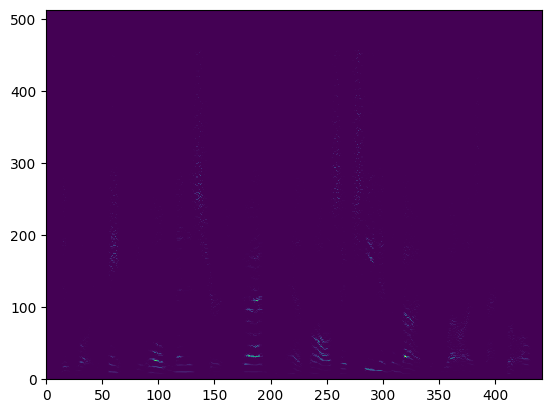

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8814e-02,
        2.3776e-02, 8.5389e-01, 6.1496e-01, 1.2529e+00, 2.1466e+00, 1.6486e+00,
        2.1495e+00, 1.9620e+00, 1.3276e+00, 9.7513e-01, 1.2606e+00, 1.7596e+00,
        1.1781e+00, 1.1787e+00, 2.9142e+00, 2.3164e+00, 1.6496e+00, 2.1217e+00,
        2.5345e+00, 4.0899e+00, 3.9449e+00, 2.7098e+00, 3.1592e+00, 3.5884e+00,
        2.8541e+00, 7.7782e+00, 4.9954e+00, 5.3237e+00, 1.5885e+00, 2.0820e+00,
        1.9001e+00, 1.4783e+00, 1.2644e+00, 6.1429e-01, 1.2064e+00, 9.2346e-01,
        6.3595e-01, 1.1389e+00, 7.5868e-01, 1.9649e+00, 1.4112e+00, 1.0007e+00,
        9.1496e-01, 4.7106e-01, 5.5563e-01, 7.7113e-01, 1.0144e+00, 8.0625e-01,
        8.9347e-01, 7.4554e-01, 9.1532e-01, 6.1543e-01, 3.3034e-01, 3.9645e-01,
        6.4876e-01, 3.2577e-01, 3.4613e-01, 4.4085e-01, 2.8476e-01, 1.7814e-01,
        2.5184e-01, 3.1661e-01, 1.5489e-01, 3.3111e-01, 2.0310e-01, 1.5364e-01,
        1.8136e-01, 2.5718e-01, 3.4662e-

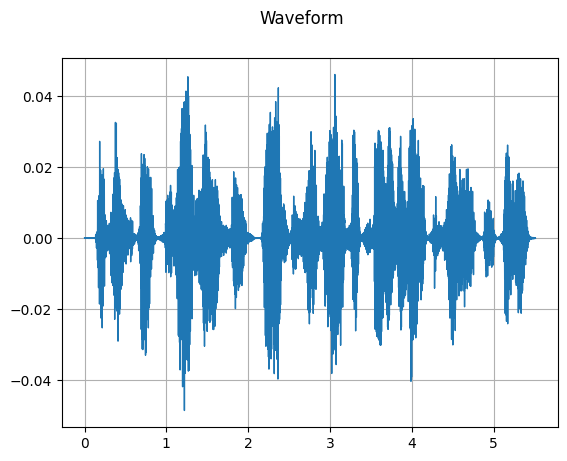

In [14]:
get_waveform_of_spec(spec)


-3.9959576 2.8846102
1e-10 4.2931786


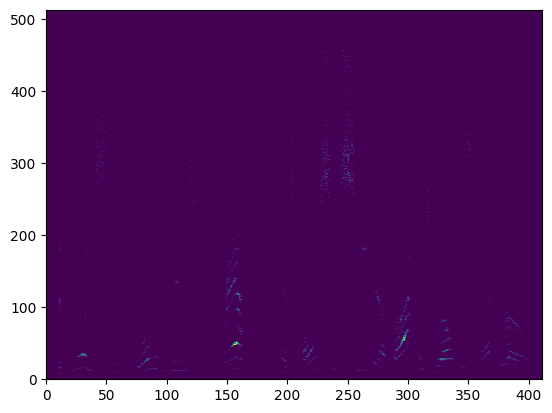

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0622e-03,
        8.0952e-03, 6.5534e-01, 1.2809e+00, 1.7614e+00, 1.0977e+00, 3.5715e+00,
        6.3330e+00, 3.4848e+00, 4.3371e+00, 2.9620e+00, 2.7121e+00, 3.2539e+00,
        2.7057e+00, 2.0415e+00, 1.6534e+00, 2.1108e+00, 2.2221e+00, 2.3552e+00,
        3.2179e+00, 4.3099e+00, 6.2259e+00, 1.2654e+01, 1.5215e+01, 1.8835e+01,
        6.3546e+00, 6.5186e+00, 3.9438e+00, 8.7959e+00, 7.9262e+00, 6.0614e+00,
        6.6657e+00, 4.7770e+00, 6.8341e+00, 6.6263e+00, 1.1972e+01, 6.9821e+00,
        2.7694e+00, 2.8824e+00, 2.1319e+00, 4.8470e+00, 5.1474e+00, 6.4588e+00,
        1.0245e+01, 1.0688e+01, 9.7098e+00, 9.5886e+00, 4.2380e+00, 5.1406e+00,
        5.9987e+00, 5.2563e+00, 4.2100e+00, 5.0544e+00, 3.0465e+00, 2.7841e+00,
        2.4595e+00, 2.7967e+00, 1.7421e+00, 1.4544e+00, 2.6577e+00, 1.2577e+00,
        2.8697e+00, 3.7747e+00, 2.0015e+00, 3.4011e+00, 2.1836e+00, 1.3854e+00,
        1.2627e+00, 1.5403e+00, 1.2078e+

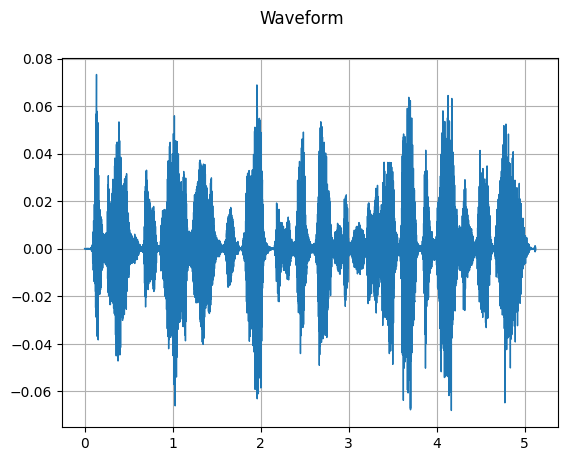

In [15]:
get_waveform_of_spec(gt_spec)